# Credit Card Customer Segmentation with KMeans

In this guided project, we’ll play the role of a data scientist working for a credit card company. We’ve been given a dataset containing information about the company’s clients and asked to help segment them into different groups in order to apply different business strategies for each type of customer.

The company expects to receive a group for each client and also an explanation of the characteristics of each group and what are the main points that make them different.

In a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

In order to use the algorithm properly and achieve all the goals that the company has set for us, we'll go through the following steps:

* Analyze the dataset;
* Prepare the data for modeling;
* Find an appropriate number of clusters;
* Segment the data;
* Interpret and explain the results.

We'll start by importing the packages we'll use.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from math import pi

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(42)

sns.set_style('whitegrid')
%matplotlib inline

# Exploratory Data Analysis


In [2]:
customers = pd.read_csv('customer_segmentation.csv')

customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [3]:
customers.shape

(10127, 14)

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

In [5]:
# check the values of the categorical columns 
for col in ['gender', 'education_level', 'marital_status']:
    print(col)
    print(customers[col].value_counts(), end='\n\n')

gender
F    5358
M    4769
Name: gender, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64



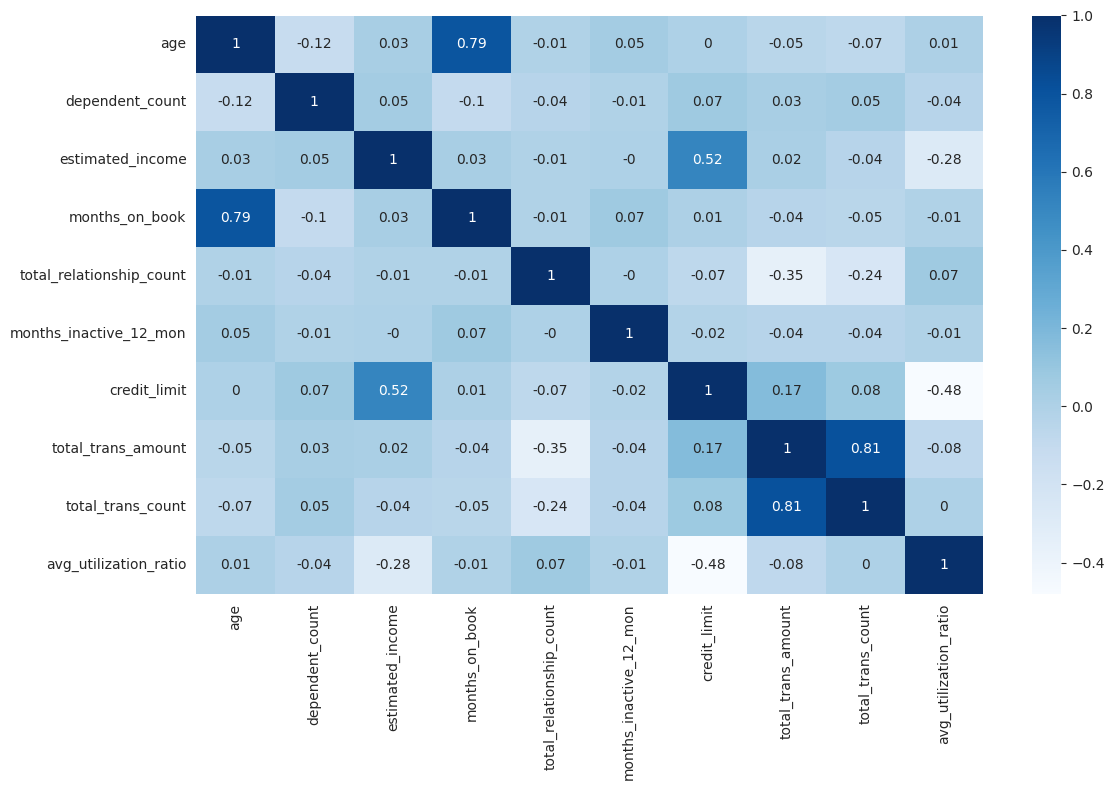

In [6]:
# check for correlations 
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(round(customers.drop('customer_id', axis=1).corr(), 2), annot=True, cmap='Blues', ax=ax)

plt.tight_layout()
plt.show()

**Notable Correlations:**
* Age is correlated with how long the person has been a customer (months_on_book)
* Credit limit is positive correlated with the estimated income and negatively correlated with the average utilization ratio
* The total number of transactions (total_trans_count) is strongly correlated with the total amount transitioned (total_trans_amount).

/tmp/ipykernel_5443/626691065.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  customers.drop('customer_id', axis=1).hist(ax=ax)


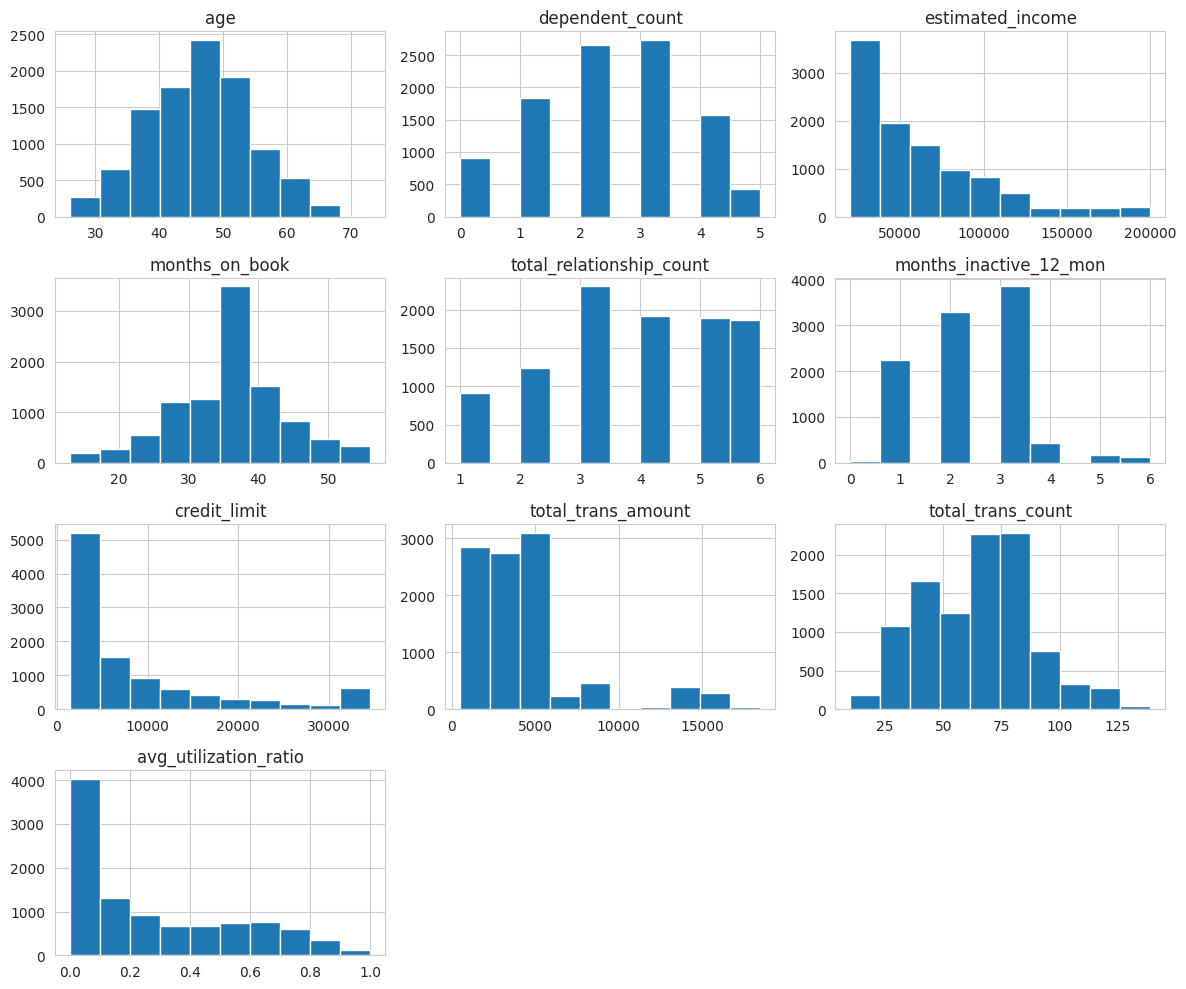

In [7]:
# plotting the distributions of each numeric columns 
fig, ax = plt.subplots(figsize=(12, 10))
customers.drop('customer_id', axis=1).hist(ax=ax)
plt.tight_layout()
plt.show()

# Feature Engineering

For Feature Engineering we will deal with the 3 categorical variables.

The `gender` columns will be replaced with 0 and 1 for Women and Men.

We'll also be able to transform the `education_level` column to numeric as following:

* Uneducated - 0
* High School - 1
* College - 2
* Graduate - 3
* Post-Graduate - 4
* Doctorate - 5

For the `marital_status` - as we can't say that any of them is higher or better than the others - we'll use one-hot-encoding to create dummy variables from this column and then drop the original variable.

In [8]:
# changing the gender column
customers_modif = customers.copy()
customers_modif['gender'] = customers['gender'].apply(lambda x: 1 if x == 'M' else 0)
customers_modif.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [9]:
# changing the education level to int
customers_modif.replace(to_replace={'Uneducated': 0, 'High School': 1, 'College':2,
                                    'Graduate': 3, 'Post-Graduate': 4, 'Doctorate':5}, inplace=True)
customers_modif['education_level'].head()

0    1
1    3
2    3
3    1
4    0
Name: education_level, dtype: int64

In [10]:
# hot encoding the marital status column
dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)

customers_modif = pd.concat([customers_modif, dummies], axis=1)
customers_modif.drop(['marital_status'], axis=1, inplace=True)

print(customers_modif.shape)
customers_modif.head()

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


# Scaling the Data

In [11]:
X = customers_modif.drop('customer_id', axis=1)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled

array([[-0.16540558,  1.05995565,  0.50336813, ...,  1.07733799,
        -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867, ..., -0.92821381,
         1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813, ...,  1.07733799,
        -0.79850685, -0.28260887],
       ...,
       [-0.29014957, -0.9434357 , -1.03646242, ...,  1.07733799,
        -0.79850685, -0.28260887],
       [-2.03656544,  1.05995565, -0.26654715, ..., -0.92821381,
        -0.79850685,  3.53845931],
       [-0.41489356, -0.9434357 , -0.26654715, ...,  1.07733799,
        -0.79850685, -0.28260887]])

# Choosing K 

We will choose the optimal number of clusters K, by calculating and plotting the silhouette score and the inierta values

In [12]:
# checking the inertia and silhouette score for K = 2-10:
X = pd.DataFrame(X_scaled)

cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9]
inertias = []
silhouette_scores = []

for k in cluster_numbers:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    fit = model.fit(X)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)
    
    silhouette_avg = silhouette_score(X, fit.labels_)
    silhouette_scores.append(silhouette_avg)
    

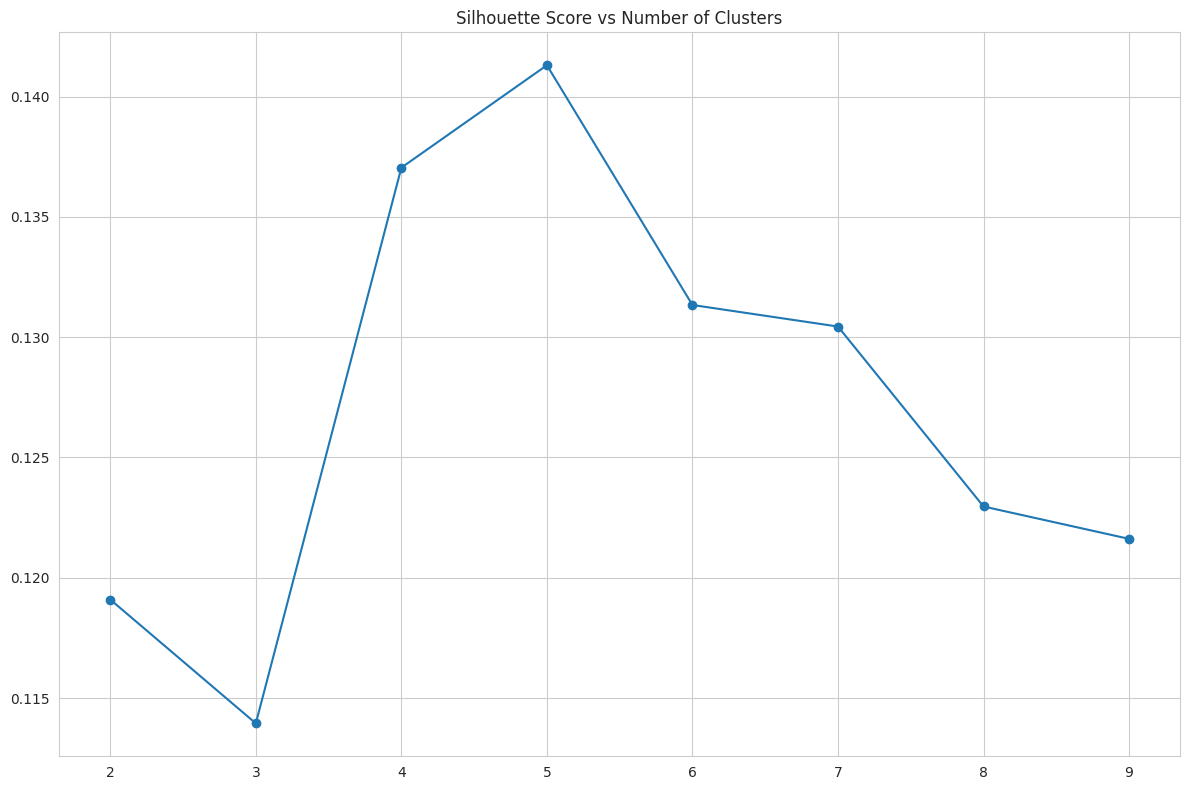

In [13]:
# plot the silhouette scores
plt.figure(figsize=(12, 8))
plt.plot(cluster_numbers, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')

plt.tight_layout()
plt.show()

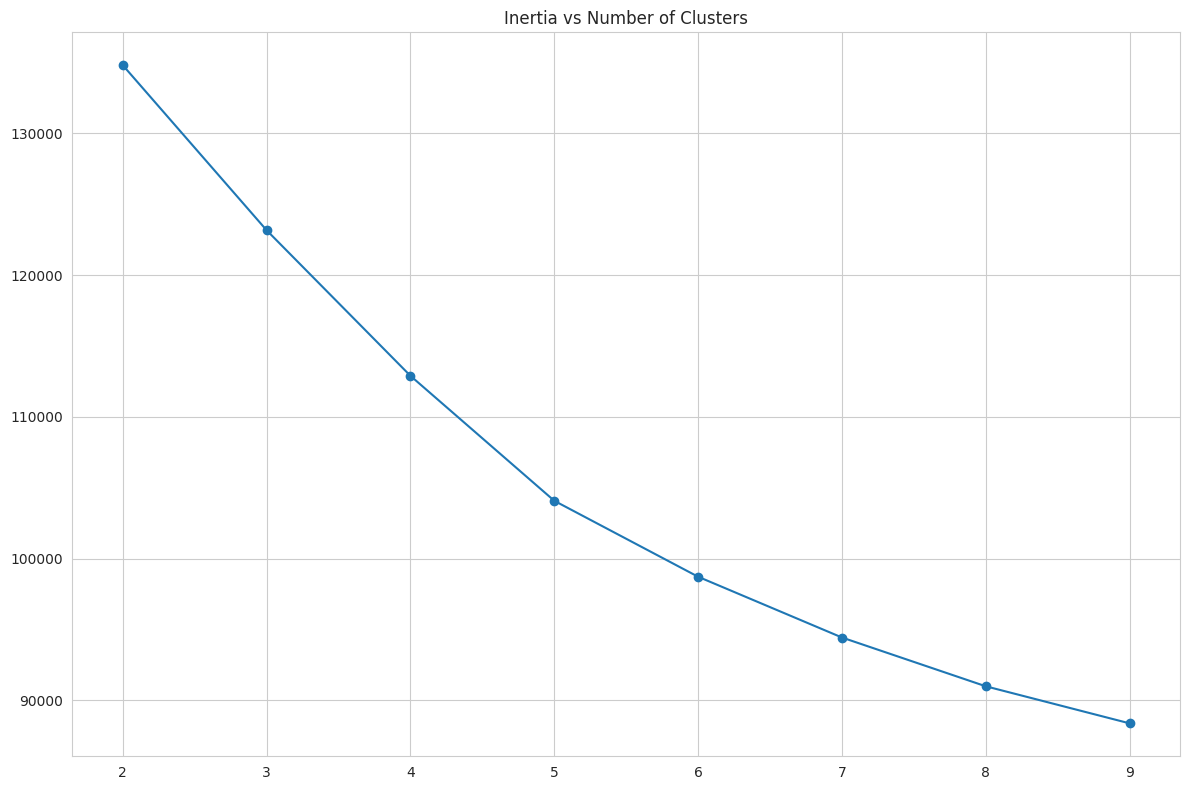

In [14]:
# plot the elbow curve to find a final K.
plt.figure(figsize=(12, 8))
plt.plot(cluster_numbers, inertias, marker='o')
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()

**Considering the two Graphs above, we'll use 5 clusters to move on.**

In [15]:
model = KMeans(n_clusters=5)
y = model.fit_predict(X_scaled)

y

array([1, 0, 1, ..., 2, 3, 2], dtype=int32)

# Analyzing Results

In [16]:
# creating a new column with the cluster number for each observation
customers['CLUSTER'] = y + 1
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,2
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,1
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,2
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,4
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,5
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,1
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,3
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,4


In [17]:
# checking the occurencies of each cluster 
round(customers['CLUSTER'].value_counts().sort_values() / len(customers) * 100,2)

4     7.30
5     9.51
2    19.80
1    29.32
3    34.08
Name: CLUSTER, dtype: float64

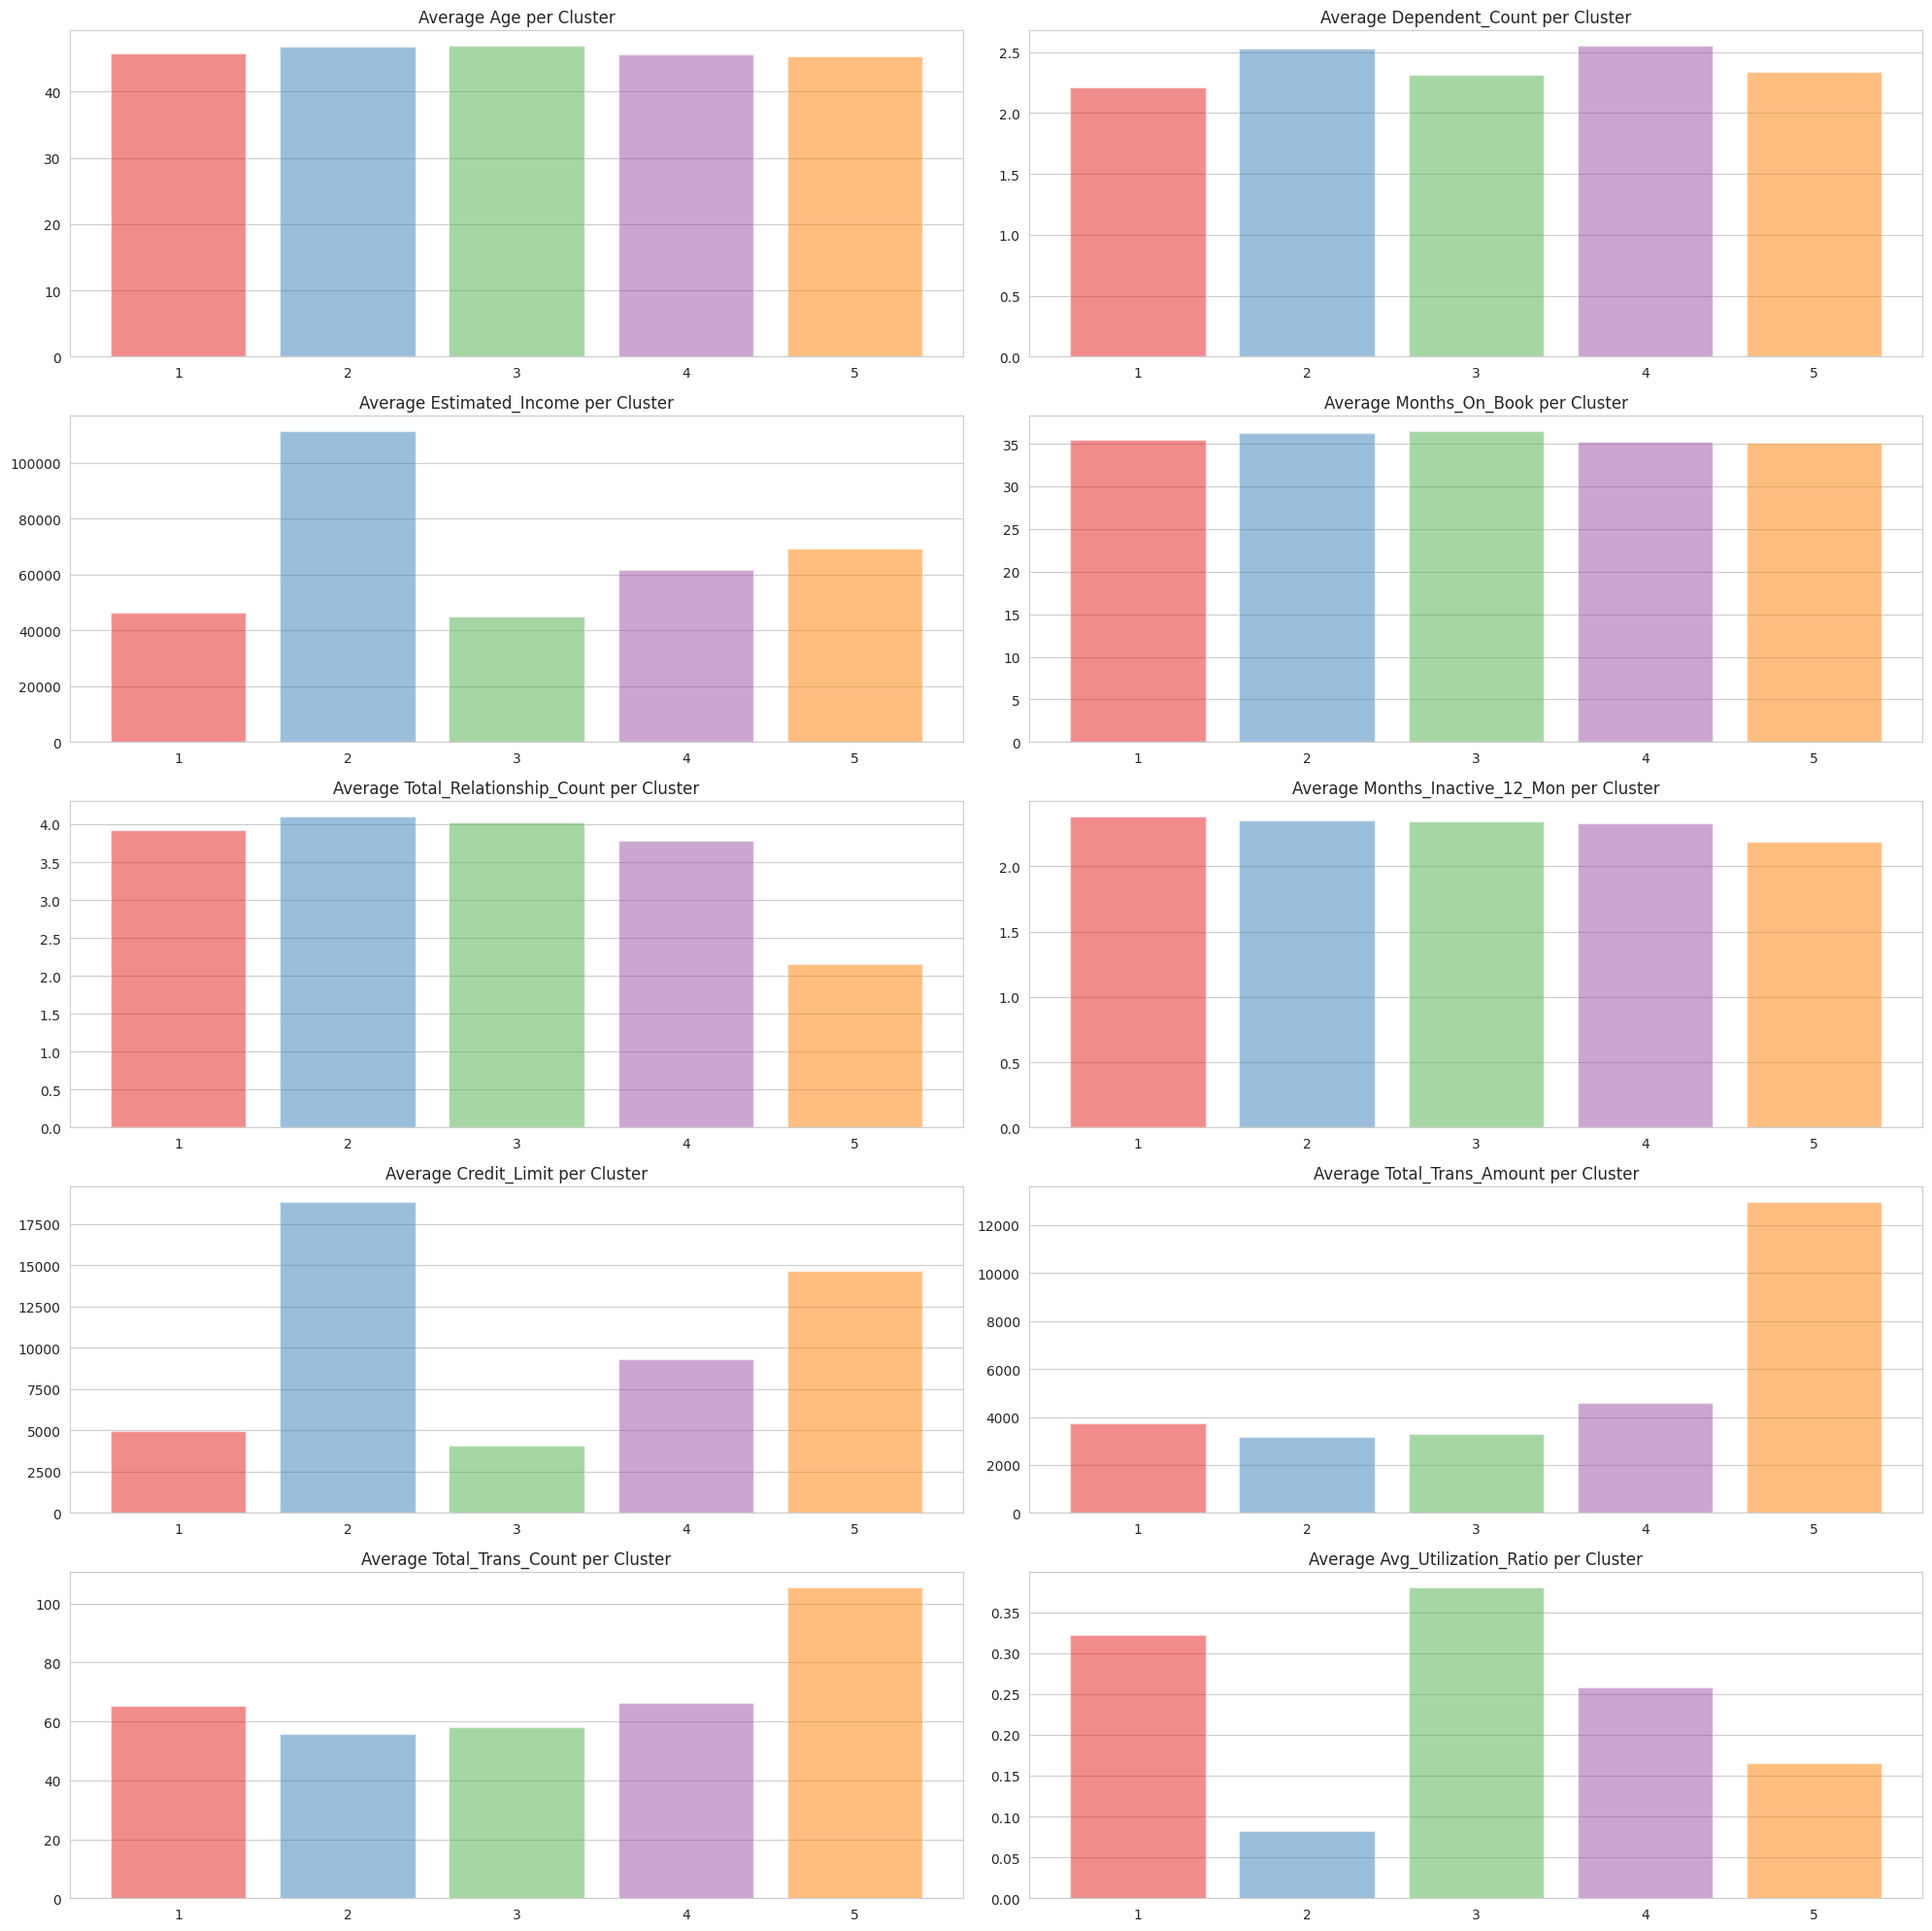

In [18]:
# chosing all relevant numeric columns and plotting the values against each cluster
numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.5)
    ax.set_title(f'Average {column.title()} per Cluster')
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

**Notable Characteristics**

Some features are fairly uniform across all clusters:

* Age
* Dependent_count
* Months_on_Books
* Months_inactive_12_mon
* Total_relationship_count
* Overview of Cluster Results:

To get a better idea of the relevant differences between the clusters we will now plot a spider graph

In [19]:
# create a df with the average values for each cluster 
rel_columns = customers[['estimated_income', 'credit_limit', 'total_trans_count', 'total_trans_amount', 'avg_utilization_ratio']]

cluster_values_df = pd.DataFrame()

for column in rel_columns:
    # Group by 'CLUSTER' and get the mean for each cluster for the current column
    cluster_values = customers.groupby('CLUSTER')[column].mean()
    # Rename the Series to be more descriptive
    cluster_values = cluster_values.rename(f'Average_{column.title()}')
    # Add the cluster values to the DataFrame
    cluster_values_df = pd.concat([cluster_values_df, cluster_values], axis=1)

# Reset the index to have 'CLUSTER' as a column
cluster_values_df.reset_index(inplace=True)

# Rename the columns in the DataFrame
cluster_values_df = cluster_values_df.rename(columns={
    'index': 'Cluster',
    'Average_Estimated_Income': 'Income',
    'Average_Credit_Limit': 'Credit Limit',
    'Average_Total_Trans_Count': 'Transaction Count',
    'Average_Total_Trans_Amount': 'Transaction Amount',
    'Average_Avg_Utilization_Ratio': 'Utilization Ratio'
})
round(cluster_values_df,2)

,Cluster,Income,Credit Limit,Transaction Count,Transaction Amount,Utilization Ratio
0,1,46474.57,4957.06,65.31,3742.91,0.32
1,2,111180.05,18820.14,55.69,3157.55,0.08
2,3,45040.28,4056.45,58.15,3273.51,0.38
3,4,61577.81,9285.00,66.46,4576.44,0.26
4,5,69394.60,14645.38,105.39,12957.16,0.17


In [20]:
# normalizing the values for the upcoming spider plot 
numeric_cols = cluster_values_df.columns[1:]  # Exclude 'index' column
scaler = MinMaxScaler()
cluster_values_df[numeric_cols] = scaler.fit_transform(cluster_values_df[numeric_cols])

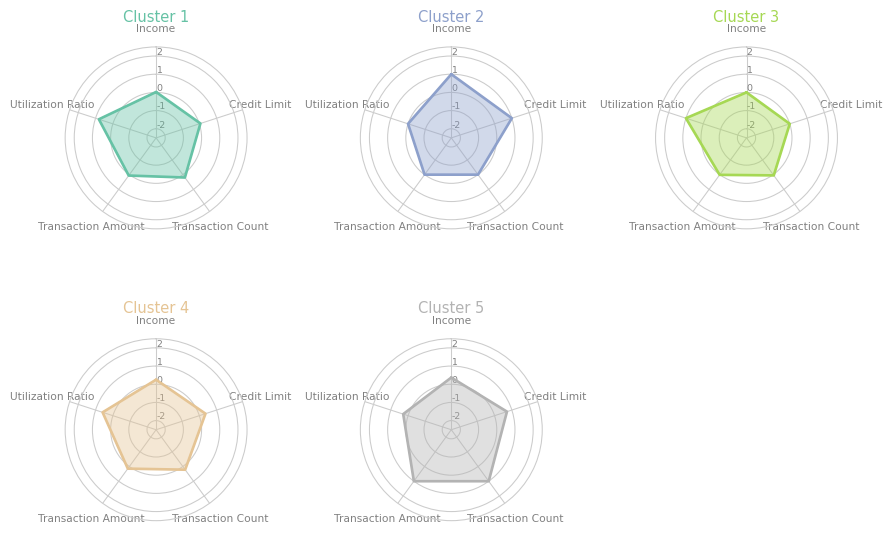

In [21]:
# creating a spider plot as seen in "https://python-graph-gallery.com/392-use-faceting-for-radar-chart/"

# ------- PART 1: Define a function that creates a spider plot for one cluster
def make_spider(row, title, color):
    categories = list(cluster_values_df.columns[1:])
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(gs[row], polar=True)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)

    ax.set_rlabel_position(0)
    plt.yticks([-2, -1, 0, 1, 2], ["-2", "-1", "0", "1", "2"], color="grey", size=7)
    plt.ylim(-2.5, 2.5)

    values = cluster_values_df.loc[row].drop('Cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    plt.title('Cluster ' + str(title), size=11, color=color, y=1.1)

# ------- PART 2: Apply the function to all clusters
my_dpi = 96
fig = plt.figure(figsize=(900/my_dpi, 600/my_dpi), dpi=my_dpi)

# Create a color palette
my_palette = plt.cm.get_cmap("Set2", len(cluster_values_df))

# Define a grid with a custom layout for the plots
n_rows = 2
n_cols = 3
gs = GridSpec(n_rows, n_cols, figure=fig)

# Loop to plot
for row in range(0, len(cluster_values_df)):
    make_spider(row=row, title=cluster_values_df['Cluster'][row], color=my_palette(row))

plt.tight_layout()
plt.show()


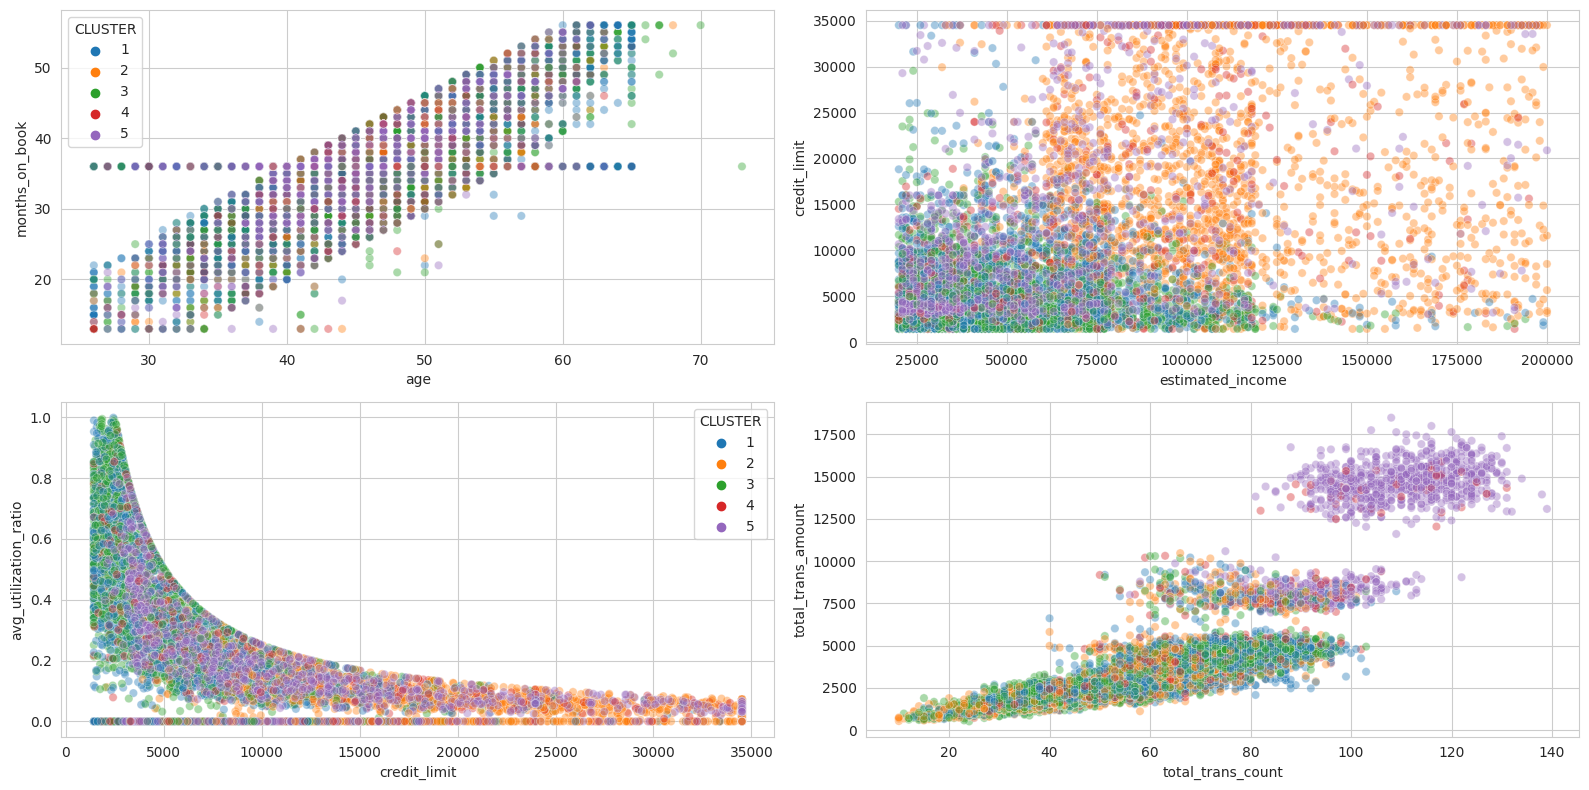

In [22]:
# plotting the numerical values with high correlation against clusters with scatter plots 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

**We can draw some early conclusions considering only the numeric variables:**

* Cluster 1 & 3 are almost identic with a low income and a correlated low credit limit and high utilization rate

* Cluster 2 has the highest income with correlated high credit limit and low utilization rate 

* Cluster 4 seems to be quite average in all categories 

* Cluster 5 are power users with medium income, credit limit and utilization rate, but with high transaction amounts and -counts. Probably Families with Kids

Let's have a look at the categorical columns


/tmp/ipykernel_5443/3332527869.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


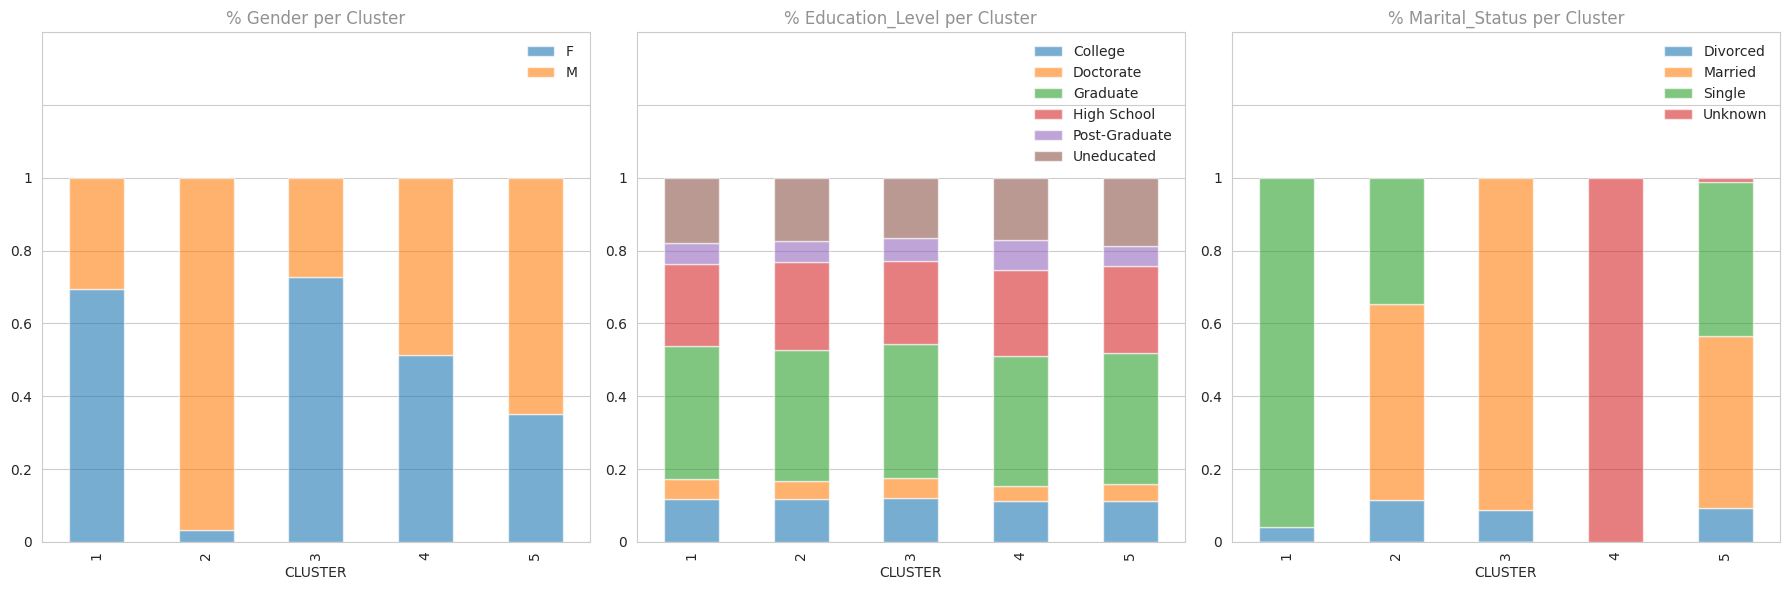

In [23]:
# plotting the percentual distribution of the categorical columns agains the clusters 
cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[col], values=customers[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

Considering the categorical variables, we notice that the education level is well divided between clusters.

In other highlights **Cluster 1** (low income) is entirely of single people, plus a few divorced ones with majority being female. **Cluster 3** (also low income) is composed almost entirely of married people, most of them female, while we don't know the marital status of anybody in **Cluster 4** (average cluster). **Cluster 2** (high income) is almost completely male and **Cluster 5** is mostly male.

# Conclusion

As demanded by the company, we now have listed the most important characteristics of each cluster. We could also some suggestions and insights into each one of them.

In the end, we have the list of customers with a cluster assigned to each one.

### Cluster 1
**Characteristics:**

Share of ~30%, mostly women; mostly single; low estimated income; low credit limit; low amount transitioned; high utilization rate.

**Insight:** 

Single people (majority women) with low income and limit but utilize too much of their credit with a few larger purchases



### Cluster 2
**Characteristics:**

Share of ~20%, mostly men; high credit limit; high amount transitioned; high number of transactions; low utilization rate.

**Insight:** 

People with high volume spent on the card, but do not use it on a daily basis. Could be incentivised to spend more.



### Cluster 3
**Characteristics:**

Share of ~34%, same as cluster 1, but mostly married 

**Insight:** 

Married people (majority women) with low income and limit. Relations to a second CreditCard in the household should be checked 


### Cluster 4
**Characteristics:**

Share of ~7%, medium income, average user, but unknown marital status 

**Insight:** 
It is very difficult to make any recommendations at this poiunt. This Cluster should be considered a wildcard and could be inspected further 


### Cluster 5
**Characteristics:**

Share of ~9,5%, mostly men, marital status well divided, power users with medium income, credit limit and utilization rate, but with high transaction amounts and -counts

**Insight:** 

Middle aged people, probably Families with Children who spend their money well distributed with a good utilization rate
